  # Main simplificado

In [50]:
# Librerías básicas
import pandas as pd
import numpy as np
from tabulate import tabulate
import math

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid",font_scale=1, palette="pastel")

#Libreria para separacion de datos train y test
import pickle
from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

from sklearn.model_selection import cross_validate, cross_val_score
 
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, r2_score,  make_scorer, roc_curve, roc_auc_score
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer


# Librerias a usar para el modelo de machine learning
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting

In [7]:
# Flag que indica, cuando es True, que es la última vez que se entrena al modelo definitivo y se puede guardar
save_pickle = False

In [8]:
def create_pipeline(model, num_cols, cat_cols):

    # Define a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', MinMaxScaler())]), num_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])

    # Create a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', model)])

    return pipeline
    

In [39]:
def model_pred(model, X, y, flag):  
    
    pipeline = create_pipeline(model, num_cols, cat_cols)
    
    # Define a column transformer
    #preprocessor = ColumnTransformer(
        #transformers=[
            #('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    #('scaler', MinMaxScaler())]), num_cols),
            #('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                    #('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])

    # Create a pipeline
    #pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                #('model', model)])

    # Define the metrics for evaluation
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted')
    }

    # Perform 5-fold cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=True)

    # Calculate overfitting as the difference between training and validation accuracy
    overfitting = (np.mean(cv_results['train_accuracy']) - np.mean(cv_results['test_accuracy'])) * 100

    y_pred = cross_val_predict(pipeline, X, y)
    


    # Store the evaluation results
    results = {
        'fit_time': np.mean(cv_results['fit_time']),
        'accuracy': np.mean(cv_results['test_accuracy']),
        'f1': np.mean(cv_results['test_f1']),
        'recall': np.mean(cv_results['test_recall']),
        'precision': np.mean(cv_results['test_precision']),
        'overfitting': overfitting,
        'cm': confusion_matrix(y, y_pred),
        'curva': roc_curve(y, y_pred, pos_label='satisfied'),
        'curva_total' : roc_auc_score(y, y_pred, pos_label='satisfied')
        
    }

    # Train the model on the entire dataset
    pipeline.fit(X, y)
    
    if flag:
        # Guardar el pipeline usando Pickle. 
        with open('data_pipeline.pkl', 'wb') as file:
            pickle.dump(pipeline, file)

    return results

In [25]:
#Lectura del dataset
df = pd.read_csv("airline_passenger_satisfaction.csv")

In [26]:
# Configura Pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)


In [27]:
# Cambiar solo 'disloyal Customer' a 'Disloyal Customer'. Acordarme de ponerlo en el pipeline
df.loc[df['Customer Type'] == 'disloyal Customer', 'Customer Type'] = 'Disloyal Customer'

In [28]:
# Para llenar los valores nulos con la media: (MIRAR SI SE IMPUTAN CON MEDIA O MEDIANA)
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())

In [29]:
# Para convertir una columna de tipo float a int 
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)

In [30]:
# Se borran las columnas que no nos hacen falta
columna_a_borrar = ['Unnamed: 0', "id"]
#df = df.drop(columna_a_borrar, axis=1, inplace=True)

In [31]:
# Outliers

In [32]:
mean = df["Flight Distance"].mean()
std = df["Flight Distance"].std()

threshold = 3 * std

outliers = df[abs(df['Flight Distance'] - mean) > threshold]

In [33]:
df = df.drop(index=outliers.index)

In [40]:
# Separación de características
num_cols = ["Age","Flight Distance","Inflight wifi service","Departure/Arrival time convenient", "Ease of Online booking",
                 "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service",
                 "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "Cleanliness", "Departure Delay in Minutes",
                 "Arrival Delay in Minutes"]

cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [41]:
modelos = [
    LogisticRegression(),
    #RandomForestClassifier(),
    #AdaBoostClassifier(n_estimators=200,  random_state=1)
    # Agrega otros modelos aquí
]

In [42]:
# Separar Variable Objetivo, target o variable dependiente de las variables independientes
df_f = pd.DataFrame(df)
y = df_f["satisfaction"]
X = df_f.drop(columns="satisfaction")

In [43]:
# Crea un diccionario para almacenar los resultados de cada modelo
resultados_por_modelo = {}

Resultados para el modelo LogisticRegression:
Fit_time: 1.70
Accuracy: 0.88
F1: 0.87
Recall: 0.88
Precision: 0.87
Overfitting: 0.02
Confusion Matrix of LogisticRegression() model is:


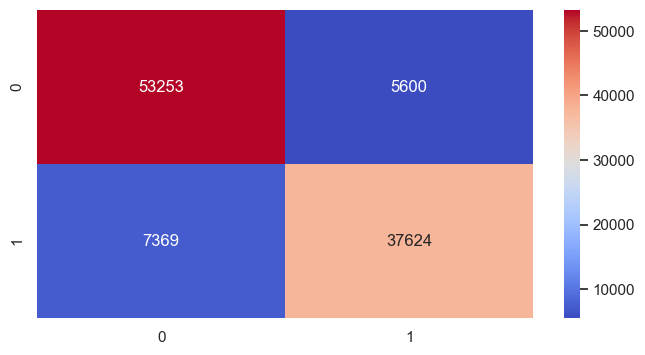

In [44]:
# Itera sobre los modelos
for modelo in modelos:
    # Entrena y evalúa el modelo actual
    resultados = model_pred(modelo, X, y, save_pickle)
    
    
    # Almacena los resultados en el diccionario
    nombre_modelo = type(modelo).__name__
    resultados_por_modelo[nombre_modelo] = resultados

# Imprime los resultados para cada modelo
for nombre_modelo, resultados in resultados_por_modelo.items():
    print(f"Resultados para el modelo {nombre_modelo}:")
    for metrica, valor in resultados.items():
        if metrica in ['fit_time', 'accuracy', 'f1', 'recall', 'precision', 'overfitting']:
            print(f"{metrica.capitalize()}: {valor:.2f}")
        if metrica in ['cm']:
            print(f"Confusion Matrix of {modelo} model is:")

    # Obtén la matriz de confusión del diccionario de resultados
    matriz_confusion = resultados['cm']

    #print(f"Confusion Matrix of {modelo} model is:")
    plt.figure(figsize=(8,4))
    sns.heatmap(matriz_confusion,annot=True,fmt="g",cmap='coolwarm')
    plt.show()

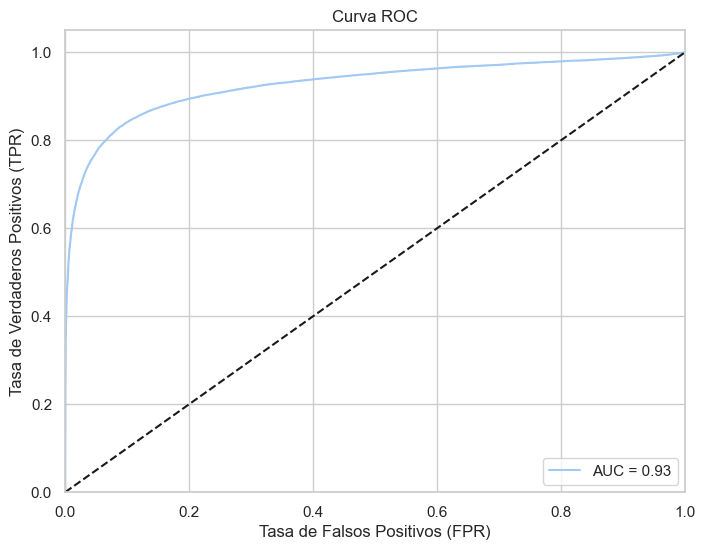

In [52]:
# Supongamos que escogemos AdaBoostClassifier. Volvemos a llamar a la función model_pred()

# Flag que indica, cuando es True, que es la última vez que se entrena al modelo definitivo y se puede guardar
save_pickle = True 

model_pred(LogisticRegression(), X, y, save_pickle)

model = LogisticRegression()
pipeline = create_pipeline(model, num_cols, cat_cols)
pipeline.fit(X, y)
y_prob = pipeline.predict_proba(X)[:, 1]
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y, y_prob, pos_label='satisfied')

# Calcular el área bajo la curva ROC (AUC)
auc = roc_auc_score(y, y_prob)
# Trazar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
save_pickle = False


In [ ]:
#model_pred(LogisticRegression(), X, y, save_pickle)

In [ ]:
#model_pred(AdaBoostClassifier(n_estimators=200,  random_state=1), X, y, save_pickle)